# Bayesian approach - Test case - 4 free parameters 

An example of applying the Bayesian approach with 4 free parameters, using the [PyMC](https://github.com/pymc-devs/pymc) package.

For more info about the method used, see the notebook [Inference_Notes](Inference_Notes.ipynb).

This example (a test case) is based on a generic dataset of 10Be concentration vs. depth, which is drawn from a distribution with given "true" parameters.

This notebook has the following external dependencies: 

In [1]:
import math

import numpy as np
import pandas as pd
import pymc
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## The mathematical (deterministic) model

The mathematical model is available in the `models` Python module (see the notebook [Models](Models.ipynb)).

In [2]:
import models

## The data

The dataset is generated using the following parameter values

In [3]:
# the true parameters 
true_erosion = 1e-3
true_exposure = 1e5
true_density = 2.0
true_inheritance = 0.

# depths and sample size
depth_minmax = [50, 500]
N = 30

# perturbations
err_magnitude = 20.
err_variability = 5.

The `gendata` Python module is used to generate the dataset (see the notebook [Datasets](Datasets.ipynb)).

In [4]:
import gendata

profile_data = gendata.generate_dataset(
    models.C_10Be,
    [true_erosion, true_exposure, true_density, true_inheritance],
    zlimits=depth_minmax,
    n=N,
    err=[err_magnitude, err_variability]
)

profile_data

,depth,C,std
0,50.000000,166682.979192,7332.451747
1,65.517241,139954.308810,6928.552484
2,81.034483,112649.875060,7144.750119
3,96.551724,95360.056162,7344.193919
4,112.068966,73394.677861,3603.947061
5,127.586207,68189.139499,5266.346626
6,143.103448,52111.003997,4900.098383
7,158.620690,40794.116289,5257.312055
8,174.137931,41211.026928,3463.789563
9,189.655172,33731.429311,3335.344529


## The statistical model (used for computing the PPD values)

PyMC allows to define the statistical model in a very nice way. The "nodes" of the model - i.e., the elements that contribute to the Posterior probability distribution - must be defined first.

- Define the prior probability distribution for each free parameter (here the uniform distribution is used, with given bounds)

In [5]:
erosion_rate = pymc.Uniform('erosion_rate', 0., 4e-3)
exposure_time = pymc.Uniform('exposure_time', 0., 4e5)
soil_density = pymc.Uniform('soil_density', 1.8, 2.3)
inheritance = pymc.Uniform('inheritance', 0, 3e5)

- Define the deterministic part, i.e., the model used to predict nucleide concentration vs. depth

In [6]:
@pymc.deterministic
def mprofile(erosion=erosion_rate, exposure=exposure_time,
             density=soil_density, inheritance=inheritance):
    """
    Modelled concentration profile.
    """
    return models.C_10Be(profile_data['depth'].values,
                         erosion, exposure,
                         density, inheritance)

- Define the distribution of measured nucleide concentrations, which is here assumed to be a Gaussian with $\mu$ is predicted by the model above and $\sigma$ the known measurement errors. The likelihood will be derived from this distribution.

In [7]:
d = pymc.Normal('data_distribution', mprofile, 1./profile_data['std']**2,
                value=profile_data['C'].values, observed=True)

PyMC builds the model automatically from all nodes.

In [8]:
smodel = pymc.Model({'erosion_rate': erosion_rate,
                     'exposure_time': exposure_time,
                     'soil_density': soil_density,
                     'inheritance': inheritance,
                     'mprofile': mprofile,
                     'data_distribution': d})

PyMC use the prior distributions to generate a random initial value for each parameter (further needed)

In [9]:
print erosion_rate.value
print exposure_time.value
print soil_density.value
print inheritance.value

0.0030383483373
353740.615011
1.92284833369
58714.6972633


The log-PPD value that correspond to the initial values is given by the `logp` attribute

In [10]:
smodel.logp

-73347.1685479176

## Fitting the statistical model

:class:`pymc.MAP` allows to "clone" a model and set all parameters to their maximum a posteriori values. It uses the scipy's [optimize](http://docs.scipy.org/doc/scipy/reference/optimize.html) package to maximize the log-PPD over the parameter space. 

In [11]:
maxppd_smodel = pymc.MAP(smodel)
maxppd_smodel.fit(method='fmin', iterlim=15000, tol=1e-6, verbose=0)

See the resulting optimized values assigned to each parameter (and compare it to the true values defined above, it should be closer than the initial values)

In [12]:
print erosion_rate.value
print exposure_time.value
print soil_density.value
print inheritance.value

0.00399999999843
398135.161274
2.2999872895
0.00526119438799


The log-PPD value at the maximum 

In [13]:
maxppd_smodel.logp_at_max

-787.696853495951

## Markov-Chain Monte-Carlo sampling

:class:`pymc.MCMC` allows to sample the parameter space following the PPD with MCMC. It is a good idea to use the results of the log-PPD maximization as initial values for MCMC. Metropolis-Hastings is the default samplerused by MCMC.

In [14]:
mcmc_smodel = pymc.MCMC(smodel)

Generate samples, discard the first $n$ samples (burn-in, `burn` argument) and keep only one sample every $t$ samples (thinning, `thin` argument) in order to obtain *idependent* samples *from the PPD*.

In [15]:
mcmc_smodel.sample(50000, burn=5000, thin=40)

 [-----------------100%-----------------] 50000 of 50000 complete in 84.6 sec

Plot some characteristics of the samples for each parameter in order to evaluate the quality of sampling.

- trace: plot of the values of the - burnt and thinned - samples (in the order of which it has been generated), useful to check if the burn-in setting was chosen appropriately (no trend visible for the firsts samples)
- acorr: autocorrelation of the values of the - burnt and thinned - samples, useful to check if the thinning setting was chosen appropriately (rapid decrease of autocorrelation)
- histogram of the samples

Plotting exposure_time
Plotting soil_density
Plotting erosion_rate
Plotting inheritance


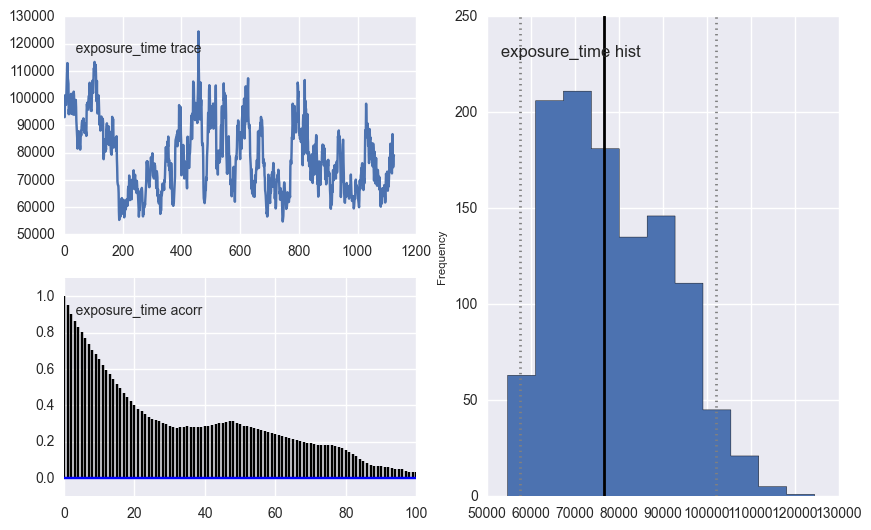

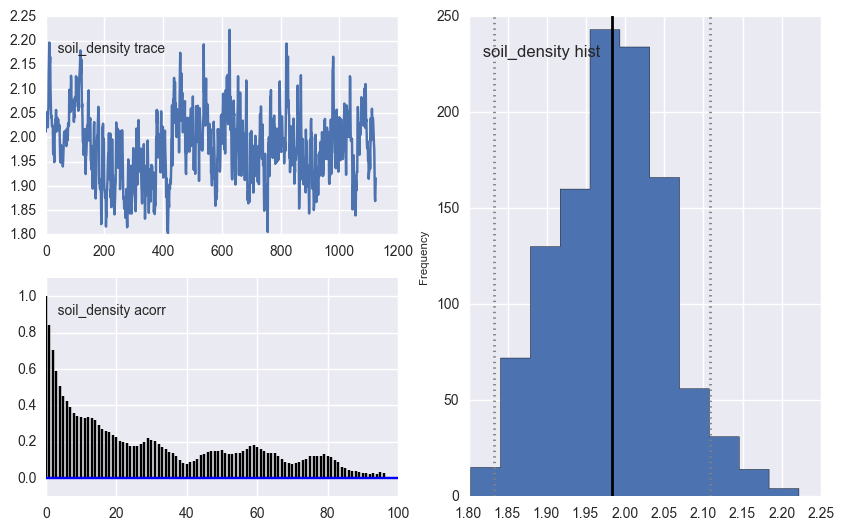

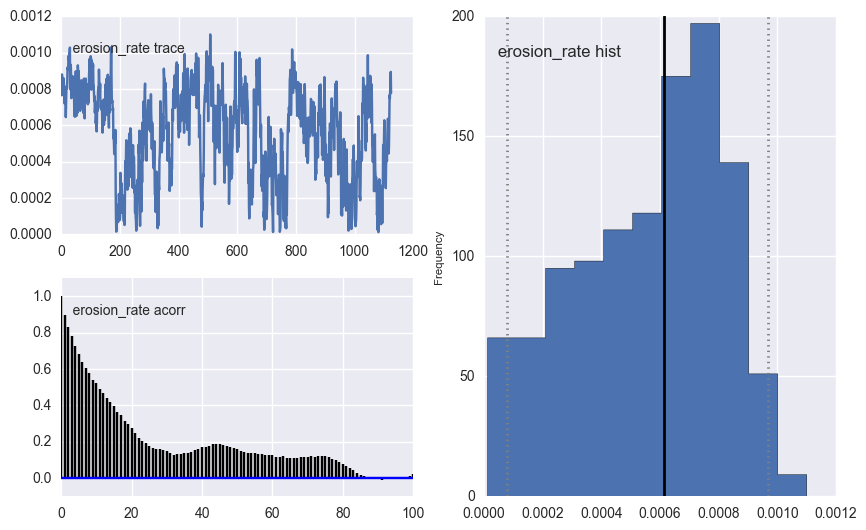

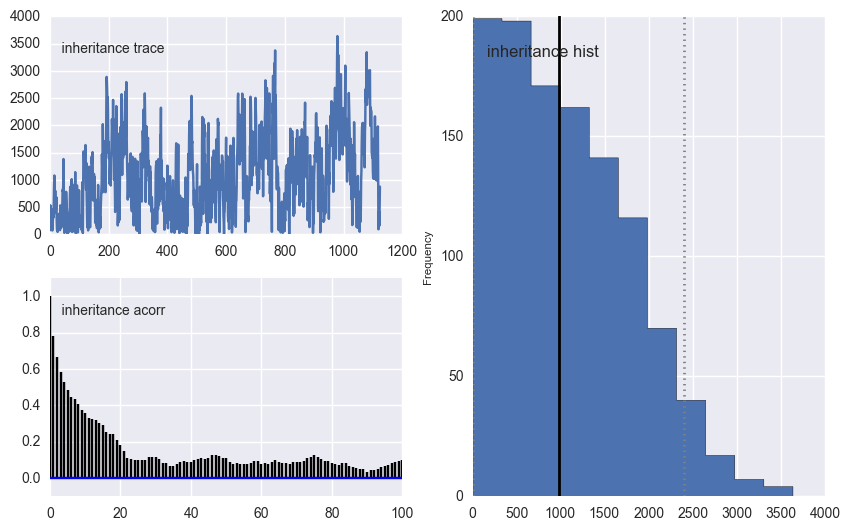

In [16]:
pymc.Matplot.plot(mcmc_smodel)

Print a summary about the distribution of the samples for each parameter. It shows the values of various moments and percentiles of the PPD, the 95% Highest Posterior Density (HPD) interval (see [here](http://www.bayesian-inference.com/credible) for an explanation) and an estimation of the Monte-Carlo integration error. 

In [17]:
mcmc_smodel.summary()


exposure_time:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	78405.582        12864.894        1195.936[  57536.206  102054.876]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	59099.561        67750.8         76585.822      88069.717     105402.98
	

soil_density:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.983            0.07             0.005            [ 1.832  2.108]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	1.852            1.933           1.983          2.029         2.129
	

erosion_rate:
 
	Mean             SD               MC Error        95% HPD inte

Show the marginal distributions of the generated samples for each parameter. Continuous lines are obtained from the samples by Kernel Density Estimation (KDE). The result is an estimation of the marginal PPD of each parameter. The red lines indicate the true values.

[]

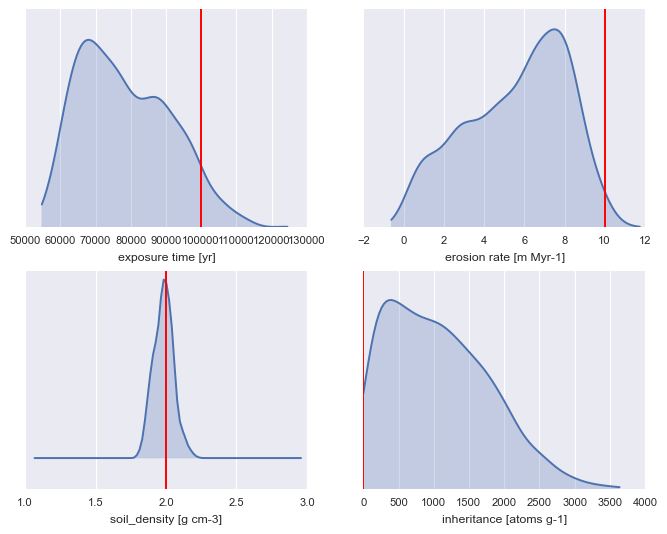

In [18]:
sns.set(style="darkgrid")
sns.set_context('paper')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

sns.distplot(mcmc_smodel.trace('exposure_time')[:], 
             hist=False, kde_kws={"shade": True},
             ax=axes[0][0])
axes[0][0].axvline(true_exposure, color='r')
axes[0][0].set_xlabel('exposure time [yr]')

sns.distplot(mcmc_smodel.trace('erosion_rate')[:] * 1e4, 
             hist=False, kde_kws={"shade": True},
             ax=axes[0][1])
axes[0][1].axvline(true_erosion * 1e4, color='r')
axes[0][1].set_xlabel('erosion rate [m Myr-1]')

sns.distplot(mcmc_smodel.trace('soil_density')[:], 
             hist=False, kde_kws={"shade": True},
             ax=axes[1][0])
axes[1][0].axvline(true_density, color='r')
axes[1][0].set_xlabel('soil_density [g cm-3]')

sns.distplot(mcmc_smodel.trace('inheritance')[:], 
             hist=False, kde_kws={"shade": True},
             ax=axes[1][1])
axes[1][1].axvline(true_inheritance, color='r')
axes[1][1].set_xlabel('inheritance [atoms g-1]')

plt.setp(axes, yticks=[])

Join plot of the generated samples with marginals, obtained by KDE. This represents an approximation of the 2D marginal PPDs. The red lines indicate the true values. 

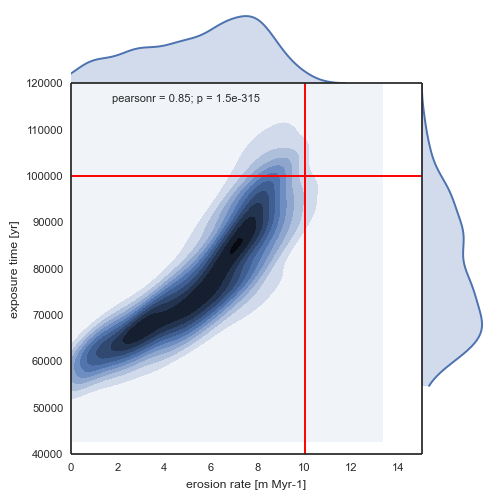

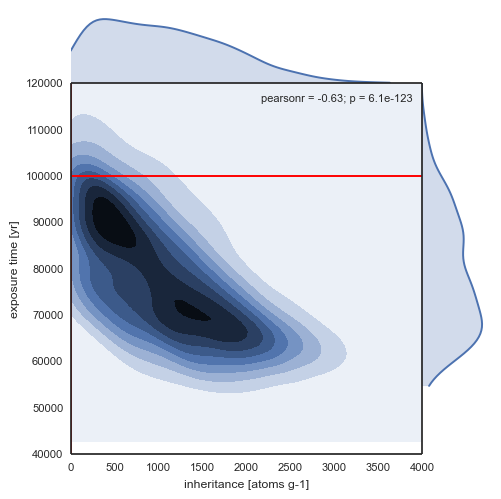

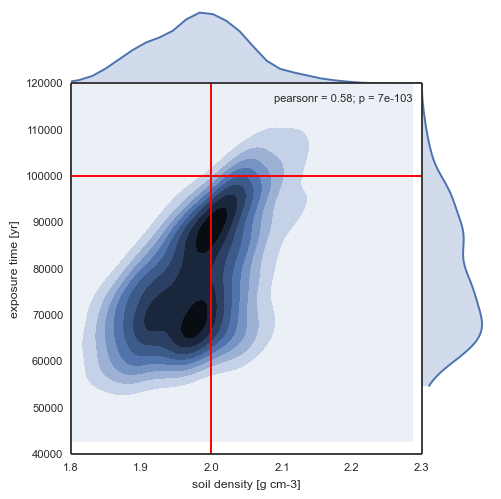

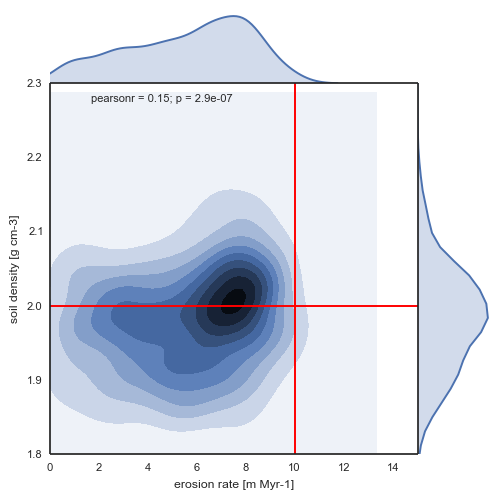

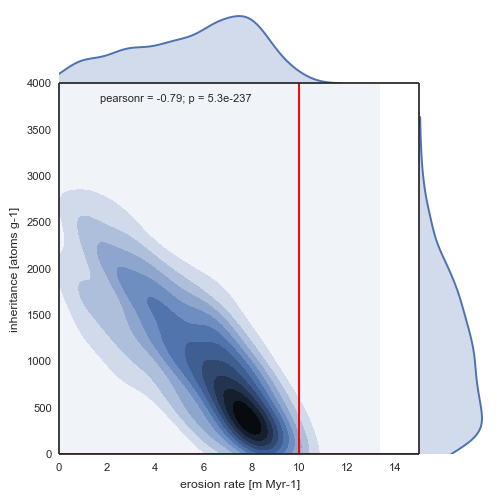

In [19]:
sns.set(style="white")
sns.set_context('paper')

# exposure vs. erosion
p = sns.jointplot(mcmc_smodel.trace('erosion_rate')[:] * 1e4,
                  mcmc_smodel.trace('exposure_time')[:],
                  xlim=[0, 15], ylim=[4e4, 1.2e5],
                  kind="kde", size=5, space=0)
plt.setp(p.ax_joint,
         xlabel='erosion rate [m Myr-1]',
         ylabel='exposure time [yr]')
p.ax_joint.axhline(true_exposure, color='r')
p.ax_joint.axvline(true_erosion * 1e4, color='r')

# exposure vs. inheritance
p = sns.jointplot(mcmc_smodel.trace('inheritance')[:],
                  mcmc_smodel.trace('exposure_time')[:],
                  xlim=[0, 4000], ylim=[4e4, 1.2e5],
                  kind="kde", size=5, space=0)
plt.setp(p.ax_joint,
         xlabel='inheritance [atoms g-1]',
         ylabel='exposure time [yr]')
p.ax_joint.axhline(true_exposure, color='r')
p.ax_joint.axvline(true_inheritance, color='r')

# exposure vs. density
p = sns.jointplot(mcmc_smodel.trace('soil_density')[:],
                  mcmc_smodel.trace('exposure_time')[:],
                  xlim=[1.8, 2.3], ylim=[4e4, 1.2e5],
                  kind="kde", size=5, space=0)
plt.setp(p.ax_joint,
         xlabel='soil density [g cm-3]',
         ylabel='exposure time [yr]')
p.ax_joint.axhline(true_exposure, color='r')
p.ax_joint.axvline(true_density, color='r')

# density vs. erosion
p = sns.jointplot(mcmc_smodel.trace('erosion_rate')[:] * 1e4,
                  mcmc_smodel.trace('soil_density')[:],
                  xlim=[0, 15], ylim=[1.8, 2.3],
                  kind="kde", size=5, space=0)
plt.setp(p.ax_joint,
         xlabel='erosion rate [m Myr-1]',
         ylabel='soil density [g cm-3]')
p.ax_joint.axhline(true_density, color='r')
p.ax_joint.axvline(true_erosion * 1e4, color='r')

# inheritance vs. erosion
p = sns.jointplot(mcmc_smodel.trace('erosion_rate')[:] * 1e4,
                  mcmc_smodel.trace('inheritance')[:],
                  xlim=[0, 15], ylim=[0, 4000],
                  kind="kde", size=5, space=0)
plt.setp(p.ax_joint,
         xlabel='erosion rate [m Myr-1]',
         ylabel='inheritance [atoms g-1]')
p.ax_joint.axhline(true_inheritance, color='r')
p.ax_joint.axvline(true_erosion * 1e4, color='r')

Plot the measured concentrations vs. depth and the predicted concentration profiles corresponding to the mean and specific quantiles of the PPD. The shaded grey area indicates the 95% HPD interval.  

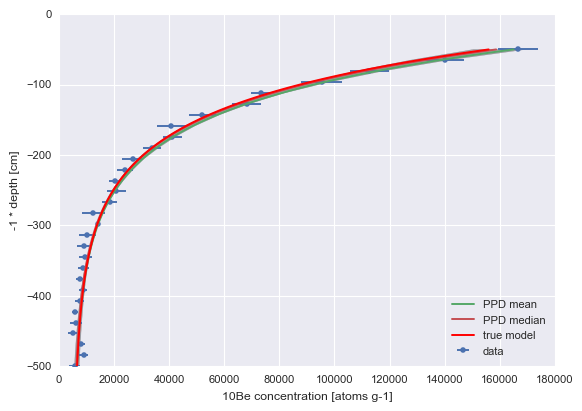

In [20]:
sns.set(style="darkgrid")
sns.set_context('paper')

depths = np.linspace(profile_data['depth'].min(),
                     profile_data['depth'].max(),
                     100)

Cm_true = models.C_10Be(depths, true_erosion, true_exposure,
                        true_density, true_inheritance)

res_erosion_rate = erosion_rate.stats()
res_exposure_time = exposure_time.stats()
res_soil_density = soil_density.stats()
res_inheritance = inheritance.stats()
res_mprofile = mprofile.stats()

Cm_mean = models.C_10Be(depths,
                        res_erosion_rate['mean'],
                        res_exposure_time['mean'],
                        res_soil_density['mean'],
                        res_inheritance['mean'])

Cm_median = models.C_10Be(depths,
                          res_erosion_rate['quantiles'][50],
                          res_exposure_time['quantiles'][50],
                          res_soil_density['quantiles'][50],
                          res_inheritance['quantiles'][50])

plt.figure()
plt.errorbar(profile_data['C'],
             -profile_data['depth'],
             xerr=profile_data['std'],
             fmt='o', markersize=4,
             label='data')
plt.plot(Cm_mean, -depths, label='PPD mean')
plt.plot(Cm_median, -depths, label='PPD median')
plt.plot(Cm_true, -depths, color='r', label='true model')
plt.fill_betweenx(-profile_data['depth'],
                  res_mprofile['95% HPD interval'][:,0],
                  res_mprofile['95% HPD interval'][:,1],
                  color='k', alpha=0.3)
plt.setp(plt.gca(),
         xlabel='10Be concentration [atoms g-1]',
         ylabel='-1 * depth [cm]',
         xlim=[0, None], ylim=[None, 0])

plt.legend(loc='lower right')

Show the correlation matrix of the free parameters (computed from the samples generated by MCMC).

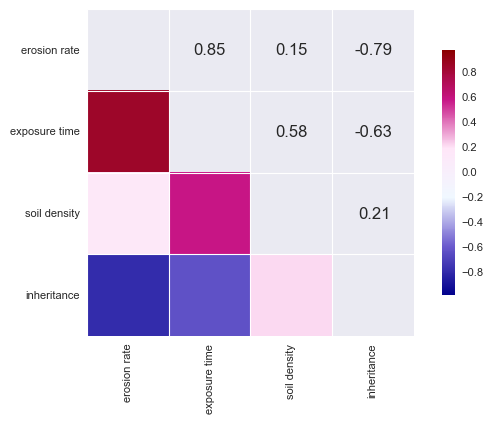

In [21]:
traces = np.column_stack((mcmc_smodel.trace('erosion_rate')[:],
                          mcmc_smodel.trace('exposure_time')[:],
                          mcmc_smodel.trace('soil_density')[:],
                          mcmc_smodel.trace('inheritance')[:]))

traces_df = pd.DataFrame(data=traces,
                         columns=['erosion rate', 'exposure time',
                                  'soil density', 'inheritance'])

f, ax = plt.subplots()
cmap = sns.blend_palette(["#00008B", "#6A5ACD", "#F0F8FF",
                          "#FFE6F8", "#C71585", "#8B0000"],
                         as_cmap=True)
sns.corrplot(traces_df, annot=True, sig_stars=False,
             diag_names=False, cmap=cmap, ax=ax)
f.tight_layout()

## Observations

*4 free parameters*

The results obtained here have similarities with the results obtained by MLE with 4 parameters (see the notebooks [GS_test_4params](GS_test_4params.ipynb) and [MLE_test_4params](MLE_test_4params.ipynb)), though the shapes of the marginal PPDs may differ significantly from those of the profile like-likelihoods.

We can aslo see that the traces and autocorrelations of erosion rate and exposure time are not as good as for the case of [2 free parameters](Bayes_test_2params.ipynb).

This shows the limit of the MCMC sampler used here (Metropolis-Hastings algorithm) in covering extended, diagonal regions of high PPD in the parameter space (this is the case here as the parameters are often strongly correlated with each other).

A solution would be to use a more robust sampler, e.g., the one implemented in the [emcee](https://github.com/dfm/emcee) Python package or the one available in PyMC version 3 (alpha). The advantage of the affine-invariant ensemble sampler implemented in emcee is that it is based on multiple, independent random walkers. Combining this with initial samples taken from the PPD evaluated on a grid search with a broad resolution would give a more robust method. 